In [ ]:
'''
File to visualize and animate a given play
'''

In [2]:
import numpy as np
import pandas as pd
import json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os

In [3]:
data_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/one_game_test_bc.pkl')


data_df.head()

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
0,2018,2018090600,677,0,0,2018-09-07T01:34:34.500,44979.0,"[[11.15, 42.28, 0.17, 2.91, 6.78, 0.0, 0.0, 11...","[[11.53, 42.45, 0.14, 1.32, 3.03, 117.3, 148.0...","[[11.62, 42.32, 0.16, 1.7, 3.13, 114.42, 144.8...",[-0.09],"[[-0.09, 0.13, -0.02, -0.38, -0.1, 2.88, 3.22,...","[[-0.16, 0.16, -0.07, -0.53, -0.24, -17.77, 7...."
1,2018,2018090600,677,0,1,2018-09-07T01:34:34.600,44979.0,"[[11.51, 42.1, 0.39, 1.64, 4.44, 0.0, 0.0, 11....","[[11.62, 42.32, 0.16, 1.7, 3.13, 114.42, 144.8...","[[11.78, 42.16, 0.23, 2.23, 3.37, 132.19, 137....",[-0.16],"[[-0.16, 0.16, -0.07, -0.53, -0.24, -17.77, 7....","[[-0.17, 0.18, -0.01, -0.4, -0.51, 6.53, 2.66,..."
2,2018,2018090600,677,0,2,2018-09-07T01:34:34.700,44979.0,"[[11.47, 42.06, 0.06, 1.2, 3.4, 0.0, 0.0, 11.4...","[[11.78, 42.16, 0.23, 2.23, 3.37, 132.19, 137....","[[11.95, 41.98, 0.24, 2.63, 3.88, 125.66, 134....",[-0.17],"[[-0.17, 0.18, -0.01, -0.4, -0.51, 6.53, 2.66,...","[[-0.21, 0.19, -0.05, -0.48, -0.22, 4.32, 3.47..."
3,2018,2018090600,677,0,3,2018-09-07T01:34:34.800,44979.0,"[[12.39, 41.68, 1.0, 0.93, 2.17, 0.0, 0.0, 12....","[[11.95, 41.98, 0.24, 2.63, 3.88, 125.66, 134....","[[12.16, 41.79, 0.29, 3.11, 4.1, 121.34, 131.2...",[-0.21],"[[-0.21, 0.19, -0.05, -0.48, -0.22, 4.32, 3.47...","[[-0.25, 0.21, -0.03, -0.44, -0.67, 2.49, 3.83..."
4,2018,2018090600,677,0,4,2018-09-07T01:34:34.900,44979.0,"[[13.5, 41.18, 1.22, 1.47, 3.5, 0.0, 0.0, 13.5...","[[12.16, 41.79, 0.29, 3.11, 4.1, 121.34, 131.2...","[[12.41, 41.58, 0.32, 3.55, 4.77, 118.85, 127....",[-0.25],"[[-0.25, 0.21, -0.03, -0.44, -0.67, 2.49, 3.83...","[[-0.32, 0.21, -0.06, -0.47, -0.03, 0.0, 9.25,..."


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [5]:
tracking2018 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2018.csv")
tracking2019 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2019.csv")
tracking2020 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2020.csv")

play_data = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/plays.csv")
returned_plays = play_data.query("specialTeamsResult == 'Return' and passResult.isnull() and penaltyYards.isnull() and (not returnerId.isnull())", engine='python', inplace=False)


In [6]:
'''
Function that splits the data into a training, validation, and test set
'''
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data_df, 0.7, 2430)

print(test_data.columns)

print(f"Length of training data: {len(train_data)}")

Index(['season', 'gameId', 'playId', 'playIndex', 'timeIndex', 'time',
       'playerId', 'football_pos', 'state', 'next_state', 'reward', 'action',
       'next_action'],
      dtype='object')
Length of training data: 140


In [18]:
all_game_numbers = np.unique(data_df.gameId)
game_id = all_game_numbers[-1]

all_play_ids = np.unique(data_df.query("gameId == @game_id").playId)
play_id = all_play_ids[0]

print(game_id)
print(play_id)

2018090900
400


number of plays =  42


/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,season,gameId,playId,playIndex,timeIndex,time,playerId,football_pos,state,next_state,reward,action,next_action
108,2018,2018090900,400,2,0,2018-09-09T17:16:35.000,42573.0,"[[103.74, 34.75, 0.6, 2.15, 3.61, 0.0, 0.0, 16...","[[105.48, 34.45, 0.33, 3.29, 1.97, 285.83, 287...","[[105.14, 34.55, 0.35, 3.55, 1.93, 289.8, 285....",[-90.62],"[[0.34, -0.1, -0.02, -0.26, 0.04, -3.97, 2.09,...","[[0.36, -0.1, -0.02, -0.26, 0.06, 5.05, 1.18, ..."


[0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


<IPython.core.display.Javascript object>


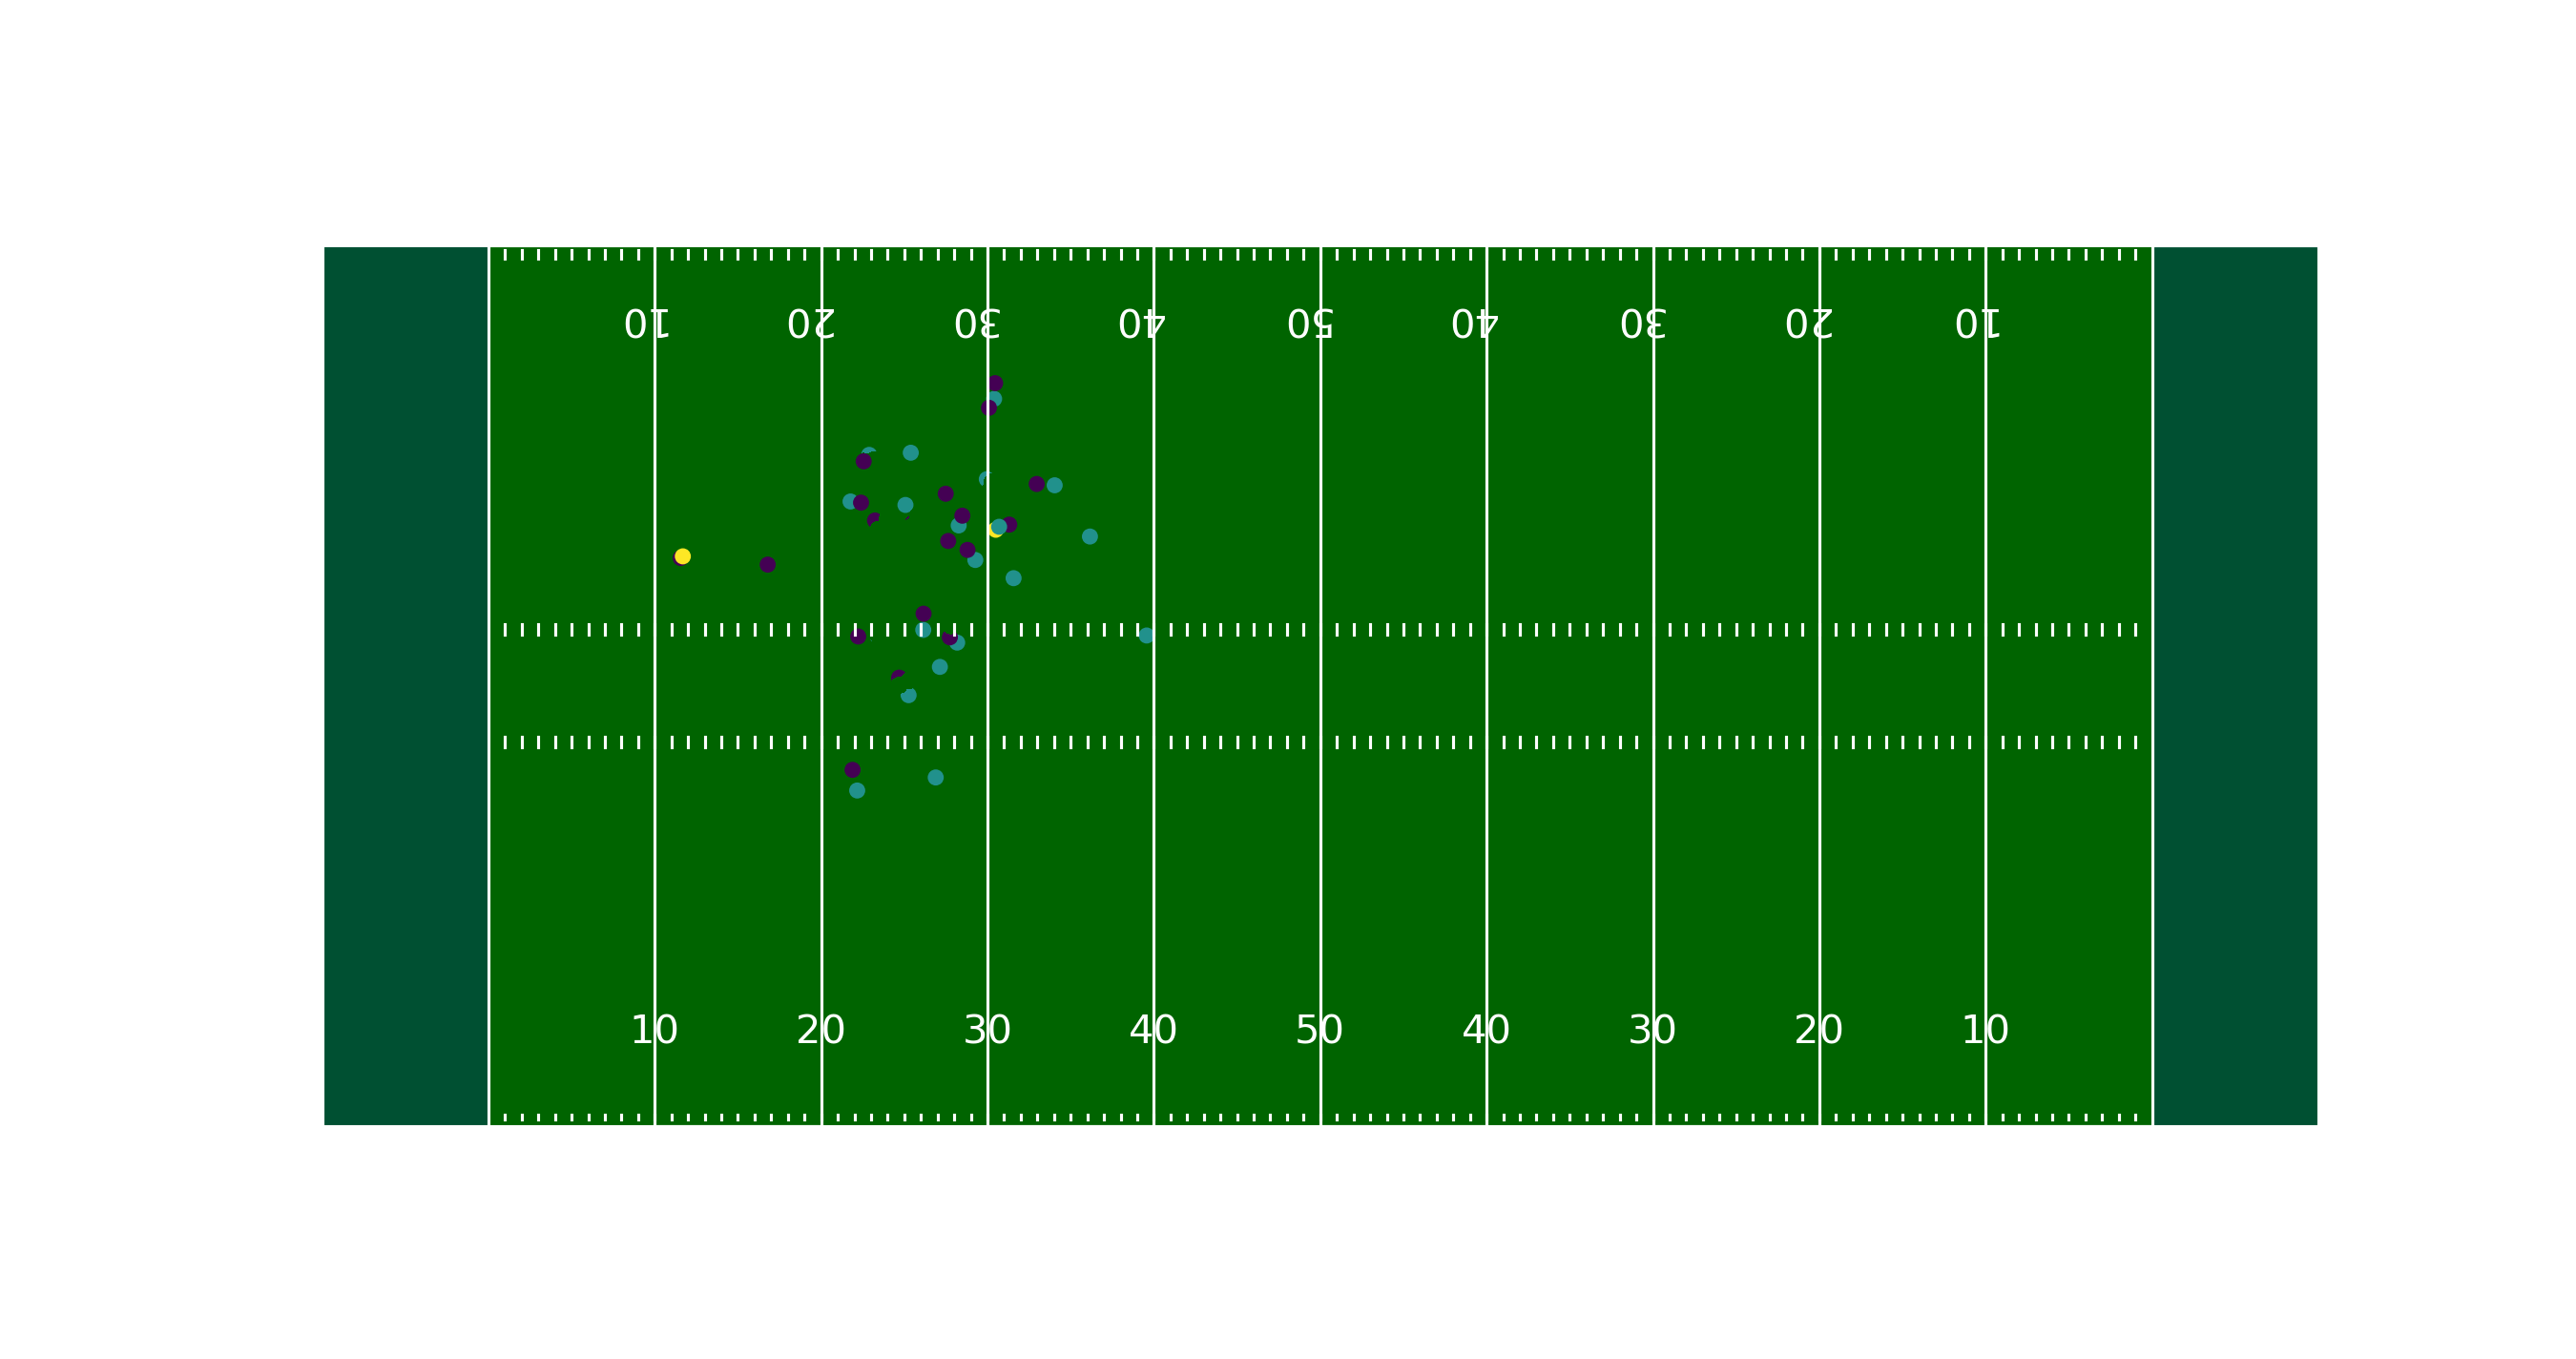

In [37]:
%matplotlib notebook


def update_plot(i, play_df, all_times, home_away, scat):
    
    time = all_times[i]
    time_df = play_df.query("time == @time")
    
    true_next_state = np.stack(time_df.loc[:,'state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(-1,8)
    
    data = np.zeros((23, 2))
    data[:,0] = true_next_state[:,2]
    data[:,1] = true_next_state[:,3] + 26
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

play_to_viz = data_df.query("gameId == @game_id and playId == @play_id")
home_away = get_home_away(returned_plays.query("gameId == @game_id and playId == @play_id"), device)
all_times = np.unique(play_to_viz.time)

#display(returned_plays.query("gameId == @game_id and playId == @play_id"))
print("number of plays = ", len(all_times))

numframes = len(all_times)
numpoints = 10

time = all_times[0]
time_df = play_to_viz.query("time == @time")
true_next_state = np.stack(time_df.loc[:,'state'])[:,:,[3,4,7,8,11,12,13,14]].reshape(-1,8)

display(time_df)
print(home_away)

fig, ax = create_football_field()
scat = ax.scatter(true_next_state[:,2],true_next_state[:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(play_to_viz, all_times, home_away, scat))
plt.show()

In [31]:
def get_distances(x, player_pos):
    dist = round(np.linalg.norm(player_pos.values - x.values),3)
    return dist

def min_teammate_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index == @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(player_of_interest_row[['x','y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

def min_opponent_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index != @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(player_of_interest_row[['x','y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

In [1]:

def modify_play_df(play_df, returnerId, playerId):
    # shift x-axis based on target's endzone
    playDirection = play_df.loc[play_df.index[0],'playDirection']
    
    if playDirection == 'left':
        play_df.insert(len(play_df.columns),'adj_x', play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 270) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 270) % 360)
    if playDirection == 'right':
        
        play_df.insert(len(play_df.columns),'adj_x', 120 - play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 90) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 90) % 360)
        
        
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'o'] = 0
    play_df.loc[play_df.team == 'football', 'dir'] = 0
    play_df.loc[play_df.team == 'football', 'adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'adj_dir'] = 0
    
    play_df['adj_o'].round(2)
    play_df['adj_dir'].round(2)
    
    play_df.insert(len(play_df.columns), 'sin_adj_o', np.sin(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'cos_adj_o', np.cos(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'sin_adj_dir', np.sin(play_df.loc[:,'adj_dir']))
    play_df.insert(len(play_df.columns), 'cos_adj_dir', np.cos(play_df.loc[:,'adj_dir']))
    
    # set football's NaN values to zero
    play_df.loc[play_df.team == 'football', 'cos_adj_o'] = 0
    play_df.loc[play_df.team == 'football', 'cos_adj_dir'] = 0
    
    
    play_df.loc[:, 'next_x'] = play_df.groupby('displayName').x.shift(-1)
    play_df.loc[:, 'next_y'] = play_df.groupby('displayName').y.shift(-1)
    play_df.loc[:, 'next_dis'] = play_df.groupby('displayName').dis.shift(-1)
    play_df.loc[:, 'next_s'] = play_df.groupby('displayName').s.shift(-1)
    play_df.loc[:, 'next_a'] = play_df.groupby('displayName').a.shift(-1)
    play_df.loc[:, 'next_o'] = play_df.groupby('displayName').o.shift(-1)
    play_df.loc[:, 'next_dir'] = play_df.groupby('displayName').dir.shift(-1)
    play_df.loc[:, 'next_adj_x'] = play_df.groupby('displayName').adj_x.shift(-1)
    play_df.loc[:, 'next_adj_y'] = play_df.groupby('displayName').adj_y.shift(-1)
    play_df.loc[:, 'next_adj_o'] = play_df.groupby('displayName').adj_o.shift(-1)
    play_df.loc[:, 'next_adj_dir'] = play_df.groupby('displayName').adj_dir.shift(-1)
    play_df.loc[:, 'next_sin_adj_o'] = play_df.groupby('displayName').sin_adj_o.shift(-1)
    play_df.loc[:, 'next_cos_adj_o'] = play_df.groupby('displayName').cos_adj_o.shift(-1)
    play_df.loc[:, 'next_sin_adj_dir'] = play_df.groupby('displayName').sin_adj_dir.shift(-1)
    play_df.loc[:, 'next_cos_adj_dir'] = play_df.groupby('displayName').cos_adj_dir.shift(-1)
    
    # remove NAs created by shifting; i.e. remove plays where there is no next play
    play_df.dropna(axis=0, how='any', subset=['x'], inplace=True)
    
    events = list(np.unique(play_df.event))

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    
    if 'kick_received' in events or 'punt_received' in events:
        received_time = play_df.query("event == 'kick_received' or event == 'punt_received'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
    if 'tackle' in events or 'out_of_bounds' in events or 'touchdown' in events or 'fumbled' in events:
        tackled_time = play_df.query("event == 'tackle' or event == 'out_of_bounds' or event == 'touchdown' or event == 'fumbled'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)

    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    #####################
    
    # get starting time of play
    #starting_time = min(play_df['time'])
    all_time_steps = runner_times.loc[:,'time'].unique()
    
    first_time = all_time_steps[0]
    
    time_play_df = runner_times.query("time == @first_time", inplace=False)
               
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df.insert(len(time_play_df.columns), 'dist_from_ball_carrier', time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],)))

    time_play_df.insert(len(time_play_df.columns), 'ball_carrier_bool', time_play_df.nflId != returnerId)
    time_play_df.insert(len(time_play_df.columns), 'player_bool', time_play_df.nflId != playerId)
    time_play_df.insert(len(time_play_df.columns), 'football_bool', time_play_df.displayName != 'football')
    time_play_df.insert(len(time_play_df.columns), 'team_index', time_play_df.team == ball_carrier_team)

    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    
    return time_play_df

In [34]:
def get_home_away(play, device):

    gameId = play.loc[:,'gameId'].values[0]
    playId = play.loc[:,'playId'].values[0]
    returnerId = float(play.loc[:,'returnerId'])
    season = str(gameId)[0:4]

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")
        
    time_play_df = modify_play_df(play_df, returnerId, returnerId)

    team_list = [1 if x == 'home' else 0 for x in time_play_df.team]
    home_away_arr = np.array(team_list)
    
    football_index = time_play_df.index[time_play_df.team == 'football']
    
    home_away_arr[football_index] = 2
    
    return home_away_arr

In [26]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax